In [1]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Enable autoreloading from src
%load_ext autoreload
%autoreload 2

In [2]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

Loading BokehJS ...

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from src.data.numba_word_vectorizer import word_word_cooccurence_matrix
from src.data.em_method import em_sparse
import scipy.sparse
from sklearn.preprocessing import normalize
from enstop import PLSA
import umap
import umap.plot
import hdbscan

[nltk_data] Downloading package punkt to /home/ava00125/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from src import workflow
from src.data import Dataset

### Read in our data

In [5]:
from sklearn.datasets import fetch_20newsgroups

## Transform data

In this case we're going to be doing a joint word-document embedding. All we need are the reviews as a list of separate documents to start with.

This part is from https://github.com/lmcinnes/umap/blob/master/notebooks/Document%20embedding%20using%20UMAP.ipynb

In [6]:
dataset_size = 3000

In [7]:
%%time
dataset = fetch_20newsgroups(subset='all',
                             shuffle=True,
                             random_state=42)

CPU times: user 253 ms, sys: 88.5 ms, total: 342 ms
Wall time: 354 ms


In [8]:
print(f'{len(dataset.data)} documents')
print(f'{len(dataset.target_names)} categories')

18846 documents
20 categories




Here are the categories of documents. As you can see many are related to one another (e.g. 'comp.sys.ibm.pc.hardware' and 'comp.sys.mac.hardware') but they are not all correlated (e.g. 'sci.med' and 'rec.sport.baseball').


In [9]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's look at a couple sample documents

In [10]:
for idx, document in enumerate(dataset.data[:3]):
    category = dataset.target_names[dataset.target[idx]]
    
    print(f'Category: {category}')
    print('---------------------------')
    # Print the first 500 characters of the post
    print(document[:500])
    print('---------------------------')

Category: rec.sport.hockey
---------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killin
---------------------------
Category: comp.sys.ibm.pc.hardware
---------------------------
From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for

Let's strip out pieces of the header and footer

In [11]:
def get_newsgroup_sections(text):
    """
    Given text in "news" format, split the header from the rest of the post.
    
    Return (header, post)
    """
    header, _blankline, after = text.partition('\n\n')
    return (header, after)


In [12]:
post = dataset.data[0]
header, body = get_newsgroup_sections(post)
print(header)
print(body)

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [13]:
def post_dict(post, idx=None):
    """
    Given a post, separate it into a dict consisting of fields from the header and the body of the post.
    """
    header, body = get_newsgroup_sections(post)

    # Separate the header items
    d = {}
    for line in header.split("\n"):
        if len(line.split(":")) >= 2:
            a, b = line.split(":", maxsplit=1)
            d[a] = b
        #else:
        #    print (f'Error splitting header {idx}: {line.split(":")}') doesn't matter.

    if len(d.keys()) == 0:
        print(f'Error {idx}: No keys')
    d['Body'] = body
    return d

In [14]:
post_dict(post)

{'From': ' Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>',
 'Subject': ' Pens fans reactions',
 'Organization': ' Post Office, Carnegie Mellon, Pittsburgh, PA',
 'Lines': ' 12',
 'NNTP-Posting-Host': ' po4.andrew.cmu.edu',
 'Body': "\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"}

In [15]:
full_dict = []
for i, line in enumerate(dataset.data):
    d = post_dict(line, idx=i)
    d['Category'] = dataset.target_names[dataset.target[i]]
    full_dict.append(d)

In [16]:
df = pd.DataFrame(full_dict)

In [17]:
df.columns

Index(['From', 'Subject', 'Organization', 'Lines', 'NNTP-Posting-Host', 'Body',
       'Category', 'Summary', 'Nntp-Posting-Host', 'Keywords',
       ...
       'organization', 'Nntp-Posting-Host-[nntpd-28159]', '        1993 17',
       'X-Alt.reply-Address', 'Nntp-Posting-Host-[nntpd-681]',
       'X-Subliminal-Message', 'XXXDate', 'XUserAgent', 'XXXMessageID',
       'NntpPostingHost'],
      dtype='object', length=148)

In [18]:
select_columns = ['From', 'Subject', 'Organization', 'Lines', 'Body', 'Category']

In [19]:
df = df[select_columns][:dataset_size]

In [20]:
df

From  \
0        Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>   
1      mblawson@midway.ecn.uoknor.edu (Matthew B Law...   
2                       hilmi-er@dsv.su.se (Hilmi Eren)   
3                      guyd@austin.ibm.com (Guy Dawson)   
4      Alexander Samuel McDiarmid <am2o+@andrew.cmu....   
...                                                 ...   
2995                       bob1@cos.com (Bob Blackshaw)   
2996             neal@cmptrc.lonestar.org (Neal Howard)   
2997                    belgarath@vax1.mankato.msus.edu   
2998                        lioness@maple.circa.ufl.edu   
2999              henry@zoo.toronto.edu (Henry Spencer)   

                                                Subject  \
0                                   Pens fans reactions   
1                Which high-performance VLB video card?   
2      Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH ...   
3                       Re: IDE vs SCSI, DMA and detach   
4                                             driver ??   
...                                                 ...   
2995                      Re: Hamza Salah, the Humanist   
2996   Re: CB750 C with flames out the exhaust!!!!--...   
2997            Re: Gamma Ray Bursters. Where are they?   
2998                      Re: Kubota Kenai/Denali specs   
2999                    Re: temperature of the dark sky   

                                           Organization Lines  \
0          Post Office, Carnegie Mellon, Pittsburgh, PA    12   
1      Engineering Computer Network, University of O...    21   
2      Dept. of Computer and Systems Sciences, Stock...    95   
3                                            IBM Austin    60   
4      Sophomore, Mechanical Engineering, Carnegie M...    15   
...                                                 ...   ...   
2995                       Corporation for Open Systems    21   
2996                      CompuTrac Inc., Richardson TX    13   
2997                           Mankato State University    53   
2998   Center for Instructional and Research Computi...    21   
2999                               U of Toronto Zoology    20   

                                                   Body  \
0     \n\nI am sure some bashers of Pens fans are pr...   
1       My brother is in the market for a high-perfo...   
2     \n\n\n|>The student of "regional killings" ali...   
3     \nIn article <1993Apr19.034517.12820@julian.uw...   
4      \n1)    I have an old Jasmine drive which I c...   
...                                                 ...   
2995  In <1993Apr24.145704.12104@cs.brown.edu> dzk@c...   
2996  \nHey, the Lone Biker of the Apocalypse (see R...   
2997  In article <1993Apr26.141114.19777@midway.uchi...   
2998  In article <1993Apr28.151652.23080@dsd.es.com>...   
2999  In article <1993Apr28.002214.16544@Princeton.E...   

                      Category  
0             rec.sport.hockey  
1     comp.sys.ibm.pc.hardware  
2        talk.politics.mideast  
3     comp.sys.ibm.pc.hardware  
4        comp.sys.mac.hardware  
...                        ...  
2995     talk.politics.mideast  
2996           rec.motorcycles  
2997                 sci.space  
2998             comp.graphics  
2999                 sci.space  

[3000 rows x 6 columns]

In [21]:
raw_text = df['Body']

In [22]:
len(raw_text)

3000

## XXX parse posts into their constituent parts

## Build Document Matrix

We will deal with documents, in this case, newsgroup posts, as follows:

A post is a multinomial distribution over our vocabulary. 

Step-by-step that means:
* A post is a bag of words
* TfidfVectorizer -> bag of words -> bag of normalized multinomial distributions over the vocabulary (i.e. weighted multinomials)
    * If we had used CountVectorizer we would have a bag of multinomial distributions
* Use Expectation-Maximization (EM) to remove the average from the matrix (think of it like projecting away from the global trends of language coming from grammar and common word usage)

In [23]:
%%time
word_matrix, token_to_index, index_to_token = word_word_cooccurence_matrix(raw_text, min_df=50)
raw_doc_matrix = TfidfVectorizer(vocabulary=token_to_index, norm='l1').fit_transform(raw_text)
raw_doc_matrix.eliminate_zeros()
print(raw_doc_matrix.shape)

(3000, 1789)
CPU times: user 7.13 s, sys: 124 ms, total: 7.25 s
Wall time: 7.26 s


In [24]:
## remove zero rows - docs that don't have any common words
is_nonempty_row = np.array(raw_doc_matrix.sum(axis=1).T)[0] != 0
text = raw_text[is_nonempty_row]
doc_matrix = raw_doc_matrix[is_nonempty_row]

In [25]:
doc_matrix.shape

(2996, 1789)

## XXX Had an issue with doing EM on the word matrix. 

Think it's because of removing documents that are the only place where a word appears. Fix this up.

### Global parameters for the joint embedding

`background_prior`: 
This is a positive number, 1 being neutral, <1 underweight and >1 overweight wrt the strength of the background. Higher will tend to make things more orthogonal, and will cluster things more tightly (in theory) at the expense of global structure.

In [26]:
background_prior = 5.0

`joint_dimension`: We will later learn a word embedding into this dimension with PLSA and then map the documents as an average of word vectors. The higher the better for accuracy, but it will be slower and more memory intensive. 300 is the word2vec range, so we started with that and it seemed good enough.

In [27]:
# tried with 100. was better than 300
# 30 was a mess again
joint_dimension = 100

## Do EM on the Document Matrix

In [28]:
%%time
D, mix_params = em_sparse(TfidfTransformer(norm='l1').fit_transform(doc_matrix), prior_noise=background_prior)

CPU times: user 2.97 s, sys: 5.85 ms, total: 2.97 s
Wall time: 2.98 s


One of the upshots of using EM is that our matrix is sparser now

In [29]:
print(f'Number of non-zero entries before EM: {raw_doc_matrix.nnz}')
print(f'Number of non-zero entries after EM:   {D.nnz}')

Number of non-zero entries before EM: 261822
Number of non-zero entries after EM:   100781


## Build the Word Matrix

Since we're doing a joint embedding, we will treat each word like a document of its context (before it and after it which we treat separately), and then embed the words in the same way that we did the documents.

More precisely, think of a word as a document of "contexts containing that word"; that is, of two sets of documents, the context windowns before the word, and the context window after the word. We treat a word as two documents, and do exactly as we did above for each document (aka. set of context windows), concatinating the result into a vector of length 2 times the size of the vocabulary. 

In [30]:
word_matrix.shape

(1789, 1789)

In [31]:
%%time
W, s_w = em_sparse(TfidfTransformer(norm='l1').fit_transform(word_matrix), prior_noise=background_prior)
Wt, s_wt = em_sparse(TfidfTransformer(norm='l1').fit_transform(word_matrix.T), prior_noise=background_prior)

CPU times: user 2.82 s, sys: 7.93 ms, total: 2.83 s
Wall time: 2.82 s


In [32]:
word_mat_directed = normalize(scipy.sparse.hstack([W, Wt]), norm='l1')

## Give the Word Matrix and Doc Matrix the same basis

Because words are related (not independent), we don't want to think of a document as the average of the 1-hot encoded vectory corresponding to each word. Instead, we want to change basis so that we can consider a document as a weighted linear combination of the word vectors. If we do this naively, we'll end up with a huge dense matrix.

Instead, let's dimension reduce the word vectors, so that we're considering a document as a weighted linear combination of word vector topics. We'll use pLSA for this. Why? It is a linear dimension reduction technique for topic modelling that takes a bag of multinomials to a bag of multinomials. This is what we want. The dimension we reduce to will be the number of latent word-topics.

In [33]:
topicer = PLSA(n_components=joint_dimension)

In [34]:
%%time
topicer.fit(word_mat_directed)

CPU times: user 28.5 s, sys: 122 ms, total: 28.7 s
Wall time: 28.7 s


PLSA(e_step_thresh=1e-32, init='random', n_components=100, n_iter=100,
     n_iter_per_test=10, random_state=None, tolerance=0.001)

In [35]:
word_by_topic = topicer.embedding_
D_low_temp = D * word_by_topic

Note that our matrix `D_low_temp` is now a dense ndarray

In [36]:
D.shape

(2996, 1789)

In [37]:
D_low_temp.shape

(2996, 100)

We've now averaged a bunch of things together again, and we have a central limit effect. We need to separate things away from the mean again. EM to the rescue!

In [38]:
D_low, s_list = em_sparse(scipy.sparse.csr_matrix(D_low_temp), prior_noise=background_prior)
D_low = D_low.todense()

## Make the Joint Embedding

In [39]:
n_docs = D_low.shape[0]
#n_docs = 2000 #died on me with the full amount

## use hellinger
w_and_d = np.vstack((word_by_topic, D_low[:n_docs]))

In [40]:
w_and_d.shape

(4785, 100)

## XXX replace this with hellinger later, check that I get the same result

Lets set up some labels to use for hovering over our data

In [41]:
df.columns

Index(['From', 'Subject', 'Organization', 'Lines', 'Body', 'Category'], dtype='object')

## What is going on here with labelling?!

In [42]:
def doc_top_words(row):
    """
    Helper function to obtain the words that a document (row) is supported on in the vocabulary.
    
    Parameters
    ----------
    row:
        a row from the document matrix
    
    Returns
    -------
    array of column indices that the row is supported on
    """
    inds = row.indices
    data = row.data
    order = np.argsort(-data)
    return inds[order]

In [43]:
col_indices = [doc_top_words(doc_matrix.getrow(i)) for i in range(doc_matrix.shape[0])]

In [44]:
col_indices[:3]

[array([1581,  275,  677, 1318, 1398, 1112,  147,  947,  710, 1610,  617,
        1223,  748,  944,  188, 1364,  882, 1309, 1577,  893, 1760, 1709,
         635,  683,  438,  682,  169,   92, 1233,  966, 1600,  883, 1081,
        1089,  561, 1273,  110,  787,  916,  268, 1545, 1454, 1615, 1735,
         770, 1598, 1045, 1404, 1683, 1441,  841,  143,  807, 1147, 1474,
         868,  165, 1590, 1705,  154, 1095, 1745, 1784,  744,  652,  156],
       dtype=int32),
 array([ 884, 1241,  307, 1179,  934,  326,  765,  755,  980, 1542,  514,
        1536, 1286,  974,  796, 1578, 1712,  716, 1686,  587,  558,  156,
        1219, 1203, 1353,  770,  250,  167, 1100,  748,  841, 1112, 1143,
        1581,  868,  165, 1053,  135,  549,  188, 1135, 1745, 1784,  744,
        1123,  652, 1580,  807], dtype=int32),
 array([1581, 1715, 1784,  198,  196,  870, 1636, 1610, 1173, 1236,  197,
        1397,  718,  748,  237,  672,  156,  232,  231, 1454,  850, 1112,
         188, 1635, 1436,  841,  798,  312,

In [45]:
supported_words_array = np.array([" ".join([index_to_token[index_list[i]] for i in range(len(index_list))]) for index_list in col_indices])

In [46]:
supported_words_array[:3]

array(['the bit fun regular season of am lot going to fans posts he lose are rule killing recent than lack worse watch final games couple game anyway about pretty man thought kind next non end put actually however let better sure since too why his those much see very should is also in out some just any they was an not with you have for and',
       'king pro bus performance local card high heaven matthew supports does suggestions ram market ideas thank ways graphics video everything email and post please right his because anyone now he is of other the just any my all edu are or with you have on for that in',
       'the weapons you armenians armenia karabakh turkish to pay price armenian search greater he baku from and azeri azerbaijan since it of are turkey shell is if by what be story military in going don say started talking will his has so with times people true your that down said no have being about russian new turks cold use well ny army then attack provided slow arms student no

In [47]:
for i, x in enumerate(df['Body'].head(3)):
    print("---------------")
    print(i)
    print("---------------")
    print(x)

---------------
0
---------------


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


---------------
1
---------------
  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI

In [48]:
# labels of the word matrix
word_array = np.array([index_to_token[x] for x in range(W.shape[0])])

In [49]:
word_array[:5], word_array[-5:]

(array(['00', '000', '01', '02', '03'], dtype='<U14'),
 array(['you', 'young', 'your', 'yourself', 'zip'], dtype='<U14'))

In [50]:
# Create a vector to color words vs. documents

In [51]:
n_words = word_by_topic.shape[0]

In [52]:
wd_labels = np.hstack((np.zeros(n_words), np.ones(n_docs)))

In [53]:
wd_labels

array([0., 0., 0., ..., 1., 1., 1.])

In [54]:
len(wd_labels)

4785

In [55]:
word_hover_df = pd.DataFrame({'text': word_array})
word_hover_df['Category'] = ['word']*len(word_array)

In [56]:
doc_hover_df = df[is_nonempty_row].copy()
doc_hover_df['text'] = supported_words_array

In [57]:
wd_hover_df = word_hover_df.merge(doc_hover_df, how="outer")

In [58]:
wd_hover_df.head(2)

text Category From Subject Organization Lines Body
0   00     word  NaN     NaN          NaN   NaN  NaN
1  000     word  NaN     NaN          NaN   NaN  NaN

In [59]:
wd_hover_df.tail(2)

text       Category  \
4783  output double both do mean yes either or can b...  comp.graphics   
4784  henry the toronto sun place point object natur...      sci.space   

                                        From  \
4783             lioness@maple.circa.ufl.edu   
4784   henry@zoo.toronto.edu (Henry Spencer)   

                               Subject  \
4783     Re: Kubota Kenai/Denali specs   
4784   Re: temperature of the dark sky   

                                           Organization Lines  \
4783   Center for Instructional and Research Computi...    21   
4784                               U of Toronto Zoology    20   

                                                   Body  
4783  In article <1993Apr28.151652.23080@dsd.es.com>...  
4784  In article <1993Apr28.002214.16544@Princeton.E...

## Dimension Reduce

And finally, use UMAP to embed the words and docs

In [60]:
%%time
mapping = umap.UMAP(n_neighbors=10, random_state=42, metric='hellinger')

CPU times: user 37 µs, sys: 1e+03 ns, total: 38 µs
Wall time: 42.7 µs


In [61]:
%%time
embedding = mapping.fit(w_and_d)

CPU times: user 38.7 s, sys: 5.28 s, total: 44 s
Wall time: 43.5 s


In [62]:
embedding.embedding_.shape

(4785, 2)

In [63]:
p = umap.plot.interactive(embedding, hover_data=wd_hover_df[['text', 'Category']], labels=wd_hover_df.Category, width=800, height=800, point_size=5);
show(p)

## On to topic modelling

Cluster the documents

In [64]:
import hdbscan

In [70]:
doc_embedding = embedding.embedding_[-n_docs:]

In [71]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(doc_embedding)

CPU times: user 81.8 ms, sys: 1.06 ms, total: 82.8 ms
Wall time: 81.5 ms


In [74]:
max(clusterer.labels_)

76

In [73]:
max(clusters)

76

Give the words a cluster label of 999

In [92]:
word_cluster_labels = np.array([999]*n_words)
doc_cluster_labels = clusterer.labels_

In [93]:
clusters = pd.Series(np.hstack([word_cluster_labels, doc_cluster_labels]))

In [88]:
wd_hover_df['Clusters'] = clusters

In [89]:
p = umap.plot.interactive(embedding, hover_data=wd_hover_df[['text', 'Category']], labels=wd_hover_df.Clusters, width=800, height=800, point_size=5);
show(p)

In [379]:
clusters.value_counts()[:10]

 999    1430
-1       559
 65      209
 55      157
 5       126
 63      103
 45       91
 34       72
 42       56
 4        54
dtype: int64

In [380]:
clusters.value_counts()[-10:]

60    17
73    16
35    16
67    16
27    16
58    16
47    16
38    15
54    15
57    13
dtype: int64

## Now compute the centroids of the clusters in the high space

In [95]:
len(doc_cluster_labels)

2996

In [99]:
# document matrix
D_low.shape

(2996, 100)

In [100]:
# word matrix
word_by_topic.shape

(1789, 100)

In [115]:
D_low[0, :].shape

(1, 100)

In [121]:
np.unique(doc_cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

In [122]:
labels = doc_cluster_labels
membership_strengths = clusterer.probabilities_
result = np.empty((labels.max() + 1, D_low.shape[1]), dtype=np.float32)

In [139]:
D_low_array = np.array(D_low)
for i in range(labels.max() + 1):
    mask = labels == i
    result[i] = (
        np.average(
            np.sqrt(D_low_array[mask]), axis=0, weights=membership_strengths[mask]
        )
        ** 2
    )
    result[i] /= result[i].sum()

In [147]:
result.shape

(77, 100)

### Now find the closest words

In [142]:
from pynndescent import NNDescent

In [158]:
%%time
index = NNDescent(np.array(word_by_topic), metric='hellinger', random_state=42)

CPU times: user 488 ms, sys: 2.09 ms, total: 490 ms
Wall time: 461 ms


/opt/software/anaconda3/envs/reproallthethings/lib/python3.8/site-packages/pynndescent/pynndescent_.py:1011: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(


I did this with topics of 15 words, but that was too many. I started getting words that looked pretty far away in the UMAP embedding. Go down to 10. Still too much. Let's try the first 5.

In [341]:
%%time
topic_words, topic_distances = index.query(result, k=5)

CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 2.85 ms


In [342]:
topic_words[:5]

array([[  86,   87,   88, 1648, 1362],
       [ 640, 1195,  161, 1399,  343],
       [ 251,  962,  787,  103,  635],
       [1421,  221, 1547, 1487, 1670],
       [  64,  665, 1563,  533,  408]], dtype=int32)

Two things:
* build the topic words for each document cluster, and 
* colour the words by their clusters in the UMAP viz to sanity check what we did

Let's do the non-clever way of getting the words into clusters

In [343]:
from collections import defaultdict

In [344]:
word_to_cluster = defaultdict(list)
cluster_to_words = defaultdict(list)
for cluster_id, word_ids in enumerate(topic_words):
    for word_idx in word_ids:
        word = index_to_token[word_idx]
        word_to_cluster[word].append(cluster_id)
        cluster_to_words[cluster_id].append(word)

In [345]:
word_to_cluster

defaultdict(list,
            {'__': [0],
             '___': [0],
             '_____': [0],
             'un': [0],
             'ron': [0],
             'first': [1],
             'place': [1],
             'another': [1],
             'second': [1],
             'changed': [1],
             'become': [2],
             'major': [2],
             'however': [2],
             'act': [2],
             'final': [2],
             'serve': [3],
             'audio': [3],
             'switch': [3],
             'source': [3],
             'using': [3],
             '486': [4],
             'fpu': [4],
             'tear': [4],
             'drug': [4],
             'computers': [4],
             'escrow': [5],
             'secret': [5],
             'block': [5],
             'keys': [5],
             'encrypted': [5],
             'henry': [6],
             'uk': [6],
             'ways': [6],
             'toronto': [6],
             'ac': [6],
             'admit': [7],
             '

In [346]:
word_hover_df

text Category Topics
0           00     word   [30]
1          000     word   [36]
2           01     word   [35]
3           02     word   [35]
4           03     word   [35]
...        ...      ...    ...
1784       you     word     []
1785     young     word     []
1786      your     word     []
1787  yourself     word     []
1788       zip     word     []

[1789 rows x 3 columns]

In [347]:
word_hover_df['Topics'] = word_hover_df.text.map(word_to_cluster)

In [352]:
def choose_doc_cluster(topics):
    if len(topics) > 1:
        return 777
    elif len(topics) == 1:
        return topics[0]
    else:
        return 999

In [353]:
word_cluster_labels = word_hover_df.Topics.map(choose_doc_cluster)

In [354]:
clusters = pd.Series(np.hstack([word_cluster_labels, doc_cluster_labels]))

In [355]:
wd_hover_df['Clusters'] = clusters

In [356]:
p = umap.plot.interactive(embedding, hover_data=wd_hover_df[['text', 'Category', 'Clusters']], labels=wd_hover_df.Category, width=800, height=800, point_size=5);
show(p)

Pick a specific cluster to observe, based on where there are clean categories or clean clusters.

Cluster 55 looks really clean as a cluster with its category. Seems to be about sports. Pick it.

Some other clean ones:
* 55: 
    * 10nn: ['team', 'game', 'games', 'baseball', 'nhl', 'sport', 'last', 'year', 'league', 'hit']
    * 5nn: ['game', 'baseball', 'nhl', 'last', 'year']
* 7:
    * 10nn: ['morality', 'admit', 'disagree', 'absolute', 'homosexuality', 'terms', 'particular', 'common', 'system', 'along']
    * 5nn: ['admit', 'homosexuality', 'terms', 'particular', 'system']
* 17: 
    * 10nn: ['material', 'shuttle', 'space', 'large', 'high', 'stuff', 'model', 'fast', 'small', 'cost']
    * 5nn: ['material', 'shuttle', 'space', 'large', 'high']
* 71: 
    * 10nn: ['apple', 'plus', 'monitor', 'model', 'board', 'comes', 'built', 'space', 'with', 'second']
    * 5nn: ['apple', 'plus', 'monitor', 'model', 'board']
* 61: ['ar', 'karabakh', 'arabs', 'quoted', 'conflict']

Even with the cleaner clusters, I'm still getting about 4-5 words scattered farther away. It's like the words are still all being pulled together too much. I'll throttle it back to 5.

What about the biggest clusters?
* 65: ['faith', 'christianity', 'our', 'saying', 'us']
* 55: ['game', 'baseball', 'nhl', 'last', 'year']
* 5: ['escrow', 'secret', 'block', 'keys', 'encrypted']
* 63: ['citizens', 'israel', 'property', 'former', 'protect']
* 45: ['police', 'control', 'by', 'found', 'in']

All of the topic words are nicely contained inside of the clusters.

What about the smallest clusters?

In [383]:
cluster_id = 45
print(cluster_to_words[cluster_id])
cluster_df = wd_hover_df[wd_hover_df.Clusters == cluster_id]
print(f"Number of docs in the cluster {len(cluster_df)}")

word_cluster_mask = word_hover_df.Topics.apply(lambda x: cluster_id in x)
doc_cluster_mask = doc_cluster_labels == cluster_id
cluster_mask = pd.Series(np.hstack([word_cluster_mask, doc_cluster_mask]))

['police', 'control', 'by', 'found', 'in']
Number of docs in the cluster 91


<IPython.core.display.Javascript object>


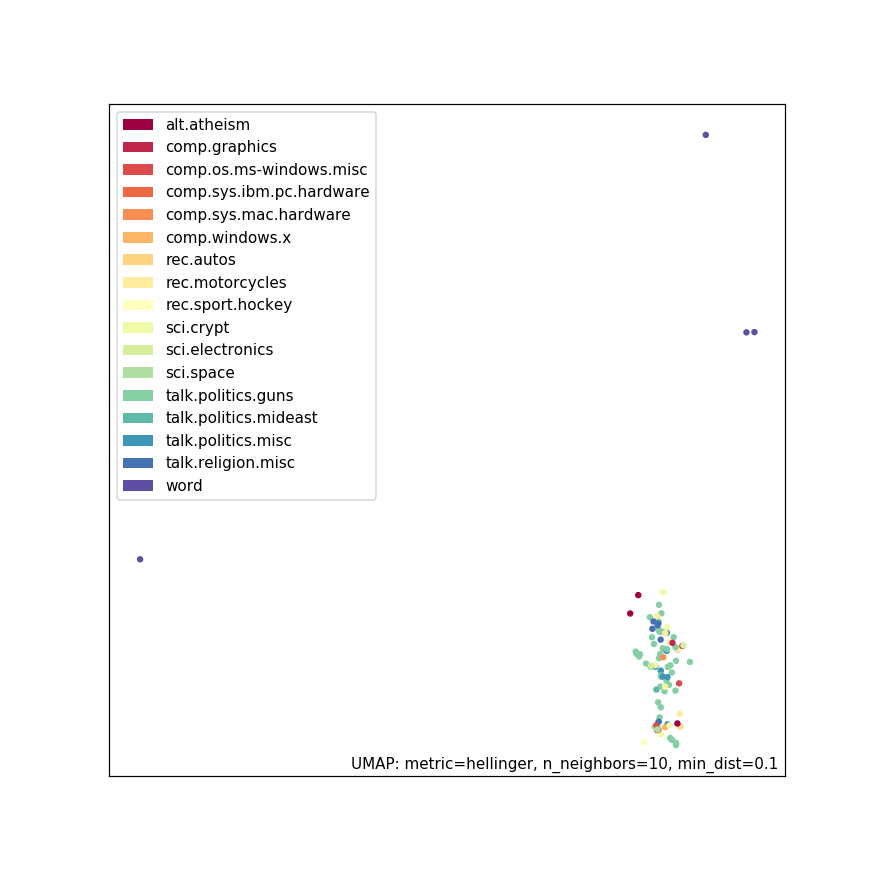

<IPython.core.display.Javascript object>


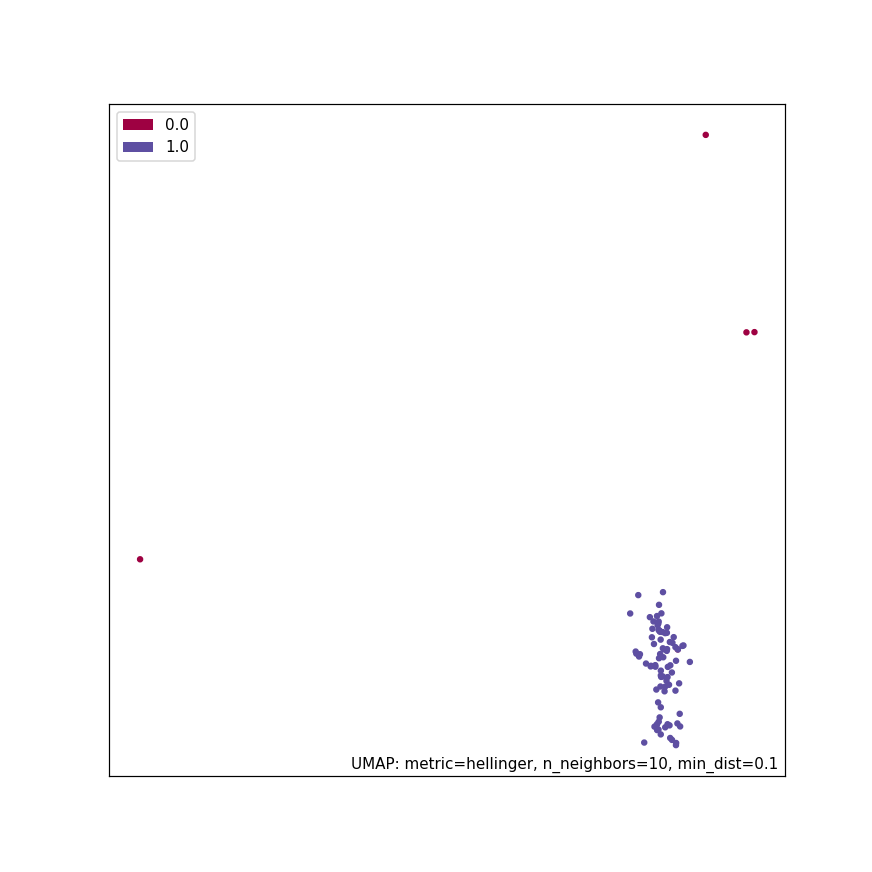

In [386]:
p = umap.plot.points(embedding,
                          labels=wd_hover_df.Category, width=800, height=800,
                          subset_points=list(cluster_mask));

q = umap.plot.points(embedding,
                          labels=wd_labels, width=800, height=800,
                          subset_points=list(cluster_mask));

### XXX Take a screenshot and file a UMAP issue here

In [304]:
p = umap.plot.interactive(embedding,
                          hover_data=wd_hover_df[['text', 'Category', 'Clusters']],
                          labels=wd_hover_df.Clusters, width=800, height=800, point_size=5,
                          subset_points=list(cluster_mask));
show(p)

ValueError: Size of subset points (4785) does not match number of input points (162)

In [ ]:
%debug

In [305]:
p = umap.plot.interactive(embedding,
                          hover_data=wd_hover_df[['text', 'Category', 'Clusters']],
                          labels=wd_hover_df.Clusters, width=800, height=800, point_size=5,
                          subset_points=cluster_idx);
show(p)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()